# Importing Libraries

In [2]:
import pandas as pd
import random
import numpy as np
import matplotlib.pyplot as plt
import datetime
import seaborn as sns
from scipy.optimize import minimize

In [3]:
%run "Stock Data.ipynb".ipynb
%run "Binance API.ipynb".ipynb
%run "RiskMetrics.ipynb".ipynb
%run "PnL Computation.ipynb".ipynb

# Importing Data

## Tickers

In [6]:
binance_api_key='E90xR7UnO2oeP3lrgC50zkqUuAqyyXs4uSlAGcqIVO9n90ELrFI4gfVI2HGGxxCj'
binance_api_secret='Inls2xYl9FqPi0zlIrucfxG81drx7w6Pv6SzYFxMNoAcwDjlCKug7zUM9zB3lF9h'
Binance=BinanceAPI(binance_api_key,binance_api_secret)

In [7]:
#stocks=pd.read_html('https://en.wikipedia.org/wiki/EURO_STOXX_50')[4]
#tickers=stocks['Ticker'].to_list()

## Market Data

In [9]:
start_date=datetime.datetime(2023,12,1)
enddate=start_date+datetime.timedelta(500)

In [10]:
quantities_api=Binance.binance_api.user_asset()
current_quantities=pd.DataFrame(quantities_api).sort_values(by='free',ascending=False)
current_quantities['asset']=current_quantities['asset']+'USDT'
current_quantities=current_quantities.set_index('asset')

In [11]:
#today_price=Binance.get_price(holding_tickers,date=datetime.datetime.today()).T
#today_price.columns=['Mark To Market']

In [12]:
trade_history=pd.read_excel('Trade History Reconstructed.xlsx')
price=get_trade_in_usdt(trade_history)

In [13]:
book_cost=get_book_cost(price)
realized_pnl,profit_and_loss=get_pnl(book_cost,price)
historical_positions=get_historical_positions(price)
historical_positions.columns=historical_positions.columns+'USDT'
historical_positions=historical_positions.sort_index()

In [14]:
price_of_positions=Binance.get_price(historical_positions.columns,datetime.datetime(2024,5,1))
price_of_positions.index=pd.to_datetime(price_of_positions.index)
price_of_positions=price_of_positions.sort_index()

In [15]:
dic={}
for key in profit_and_loss:
    dic[key]=profit_and_loss[key].to_dict()

In [16]:
realized_pnl_time=pd.DataFrame(dic).sort_index().ffill().fillna(0)
realized_pnl_time.index=pd.to_datetime(realized_pnl_time.index).round(freq='d')
realized_pnl_time=realized_pnl_time.groupby(realized_pnl_time.index).sum()

In [17]:
tickers=Binance.get_market_cap()['Ticker'].iloc[:75].to_list()
holding=Binance.get_inventory()
condition=holding.index!='Total'
holding_tickers=holding.index[condition]
holding_tickers=holding_tickers.to_list()
tickers=sorted(list(set(tickers+holding_tickers)))
last_book_cost=book_cost.iloc[-1]
pnl=pd.concat([last_book_cost,holding.loc[condition],realized_pnl],axis=1)
pnl.columns=['Book Cost','Price in USDT','Weights','Realized PnL']
pnl['Book Cost']=(pnl['Book Cost']*current_quantities['free'].astype(float))
pnl['Unrealized PnL']=(pnl['Price in USDT']-pnl['Book Cost']).round(2)
pnl=pnl.fillna(0)
pnl['Weights']=pnl['Weights'].round(4)
pnl['Total PnL']=pnl['Unrealized PnL']+pnl['Realized PnL']
pnl.loc['Total']=pnl.sum()
pnl.sort_values(ascending=False,by='Price in USDT')

,Book Cost,Price in USDT,Weights,Realized PnL,Unrealized PnL,Total PnL
Total,2184.935036,4148.616067,0.9999,-131.886217,1963.68,1831.793783
OMUSDT,526.319895,1808.535706,0.4359,0.000000,1282.22,1282.220000
BTCUSDT,601.021649,907.773701,0.2188,3.537078,306.75,310.287078
JASMYUSDT,387.458505,571.970640,0.1379,0.000000,184.51,184.510000
SOLUSDT,281.200518,393.324540,0.0948,0.000000,112.12,112.120000
ETHUSDT,250.747339,269.393214,0.0649,0.000000,18.65,18.650000
TRXUSDT,76.868953,138.529835,0.0334,-10.723889,61.66,50.936111
BBUSDT,60.176053,57.868502,0.0139,-39.733101,-2.31,-42.043101
BNBUSDT,1.142121,1.219922,0.0003,-10.606040,0.08,-10.526040
PEPEUSDT,0.000004,0.000006,0.0000,-38.521986,0.00,-38.521986


In [18]:
data1=Binance.get_price(tickers,start_date)
data2=Binance.get_price(tickers,enddate)
data=data1.combine_first(data2)
data.index=pd.to_datetime(data.index)
#data=data.dropna(axis=1)
n=len(data.columns)
data=data.sort_index()

In [19]:
inventory_weights=(holding['Weights'].apply(lambda x: np.round(x,2))).to_dict()
inventory_weights.pop('Total')

if "USDTUSDT" in inventory_weights:
    
    inventory_weights.pop('USDTUSDT')
else: 
    pass

In [20]:
returns=np.log(1+data.pct_change())
returns.index=pd.to_datetime(returns.index)
with_no_na=returns.columns[np.where((returns.isna().sum()<30))]
returns_to_use=returns[with_no_na]
ex_ante_perf=returns[holding_tickers]
ex_ante_perf_to_use=ex_ante_perf.dropna()

In [21]:
weights_post=dict()

for col in ex_ante_perf.columns:
    
    if col in inventory_weights.keys():
        weights_post[col]=inventory_weights[col]
        
    else:
        weights_post[col]=0
    
current_weights=np.array(list(weights_post.values()))
current_weights=np.round(current_weights,2)/np.sum(np.round(current_weights,2))

## Positions, Historical Performance and PnL

In [23]:
position=pd.read_excel('Positions.xlsx',index_col=0)

positions,quantities=Binance.get_positions_history(enddate=datetime.datetime.today())
positions=positions.sort_index()

positions.index=pd.to_datetime(positions.index)
positions=pd.concat([position,positions])
positions=positions.loc[~positions.index.duplicated(),:]

positions.to_excel('Positions.xlsx')

positions=positions.interpolate()
positions['Total']=positions.sum(axis=1)

In [24]:
quantities_history=pd.read_excel('Quantities.xlsx',index_col=0)

quantities.index=pd.to_datetime(quantities.index)

quantities=pd.concat([quantities,quantities_history])
quantities=quantities.loc[~quantities.index.duplicated(),:]
quantities=quantities.sort_index()

quantities.to_excel('Quantities.xlsx')

quantities_tickers=list(quantities.columns)

In [25]:
price_pnl=Binance.get_price(quantities_tickers,date=quantities.index[0])

In [26]:
price_pnl.index=pd.to_datetime(price_pnl.index)
pnl_history=pd.DataFrame()
pnl_history.index=quantities.index
pnl_history=pnl_history.sort_index()
for col in quantities:
    
    pnl_history[col]=quantities[col]*(price_pnl[col]-book_cost.iloc[-1][col])

pnl_history['Total']=pnl_history.sum(axis=1) +realized_pnl.sum()[0]

C:\Users\Admin\AppData\Local\Temp\ipykernel_4368\1175112299.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pnl_history['Total']=pnl_history.sum(axis=1) +realized_pnl.sum()[0]


In [27]:
pnl_history['Total']-pnl_history['Total'].shift(1)

2024-09-23           NaN
2024-09-24     23.503339
2024-09-25     -7.470131
2024-09-26     85.699217
2024-09-27     16.519121
                 ...    
2024-12-10    169.223224
2024-12-11    263.766653
2024-12-12   -134.094487
2024-12-13     14.587632
2024-12-14    -66.766165
Name: Total, Length: 83, dtype: float64

In [266]:
pnl_history['Total']

2024-09-23    -378.365173
2024-09-24    -354.861834
2024-09-25    -362.331965
2024-09-26    -276.632747
2024-09-27    -260.113627
                 ...     
2024-12-10    1725.847669
2024-12-11    1989.614322
2024-12-12    1855.519835
2024-12-13    1870.107467
2024-12-14    1803.341302
Name: Total, Length: 83, dtype: float64

In [ ]:
#eurusd=Binance.get_price(['EURUSDT'],date=pnl_history.index[0])

In [29]:
ptf_tickers=list(positions.columns)
ptf_tickers.remove('USDTUSDT')

In [30]:
weights_ex_post=positions.copy()
weights_ex_post=weights_ex_post.drop(columns=['USDTUSDT'])
weights_ex_post=weights_ex_post.apply(lambda x: x/weights_ex_post['Total'])

In [31]:
binance_data=Binance.get_price(ptf_tickers,date=datetime.datetime(2024,5,11))
binance_data.index=pd.to_datetime(binance_data.index)
binance_data=binance_data.sort_index()
binance_data=np.log(1+binance_data.pct_change())


LDUMAUSDT not retrieved
Total not retrieved


C:\Users\Admin\AppData\Local\Temp\ipykernel_4368\974280261.py:4: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  binance_data=np.log(1+binance_data.pct_change())


In [32]:
weight_date=set(weights_ex_post.index)
binance_date=binance_data.index

In [33]:
common_date=binance_date.intersection(weight_date)

binance_data=binance_data.loc[common_date]

In [34]:
historical_ptf=pd.DataFrame()

for col in binance_data:
    historical_ptf[col]=weights_ex_post[col]*binance_data[col]
    
historical_ptf['Historical Portfolio']=historical_ptf.sum(axis=1)

<Axes: >

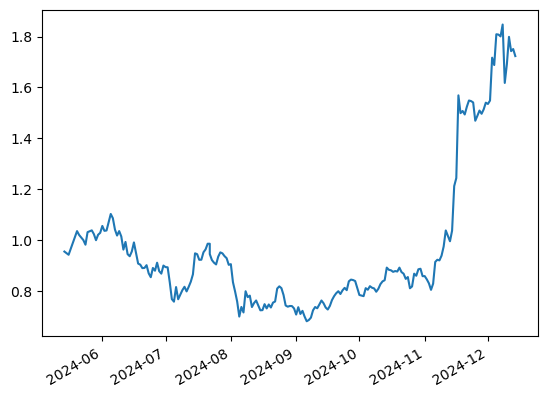

In [35]:
#historical_ptf.dropna(axis = 0, how = 'all', inplace = True)

(1+historical_ptf['Historical Portfolio']).cumprod().plot()

## Ex ante data

In [37]:
ex_ante_ptf=ex_ante_perf.copy()

for key in inventory_weights.keys():
    
    ex_ante_ptf[key]=ex_ante_perf[key]*inventory_weights[key]

ex_ante_ptf=pd.DataFrame(ex_ante_ptf.sum(axis=1))

# Portfolio Optimization

## Class set up

In [40]:
historical_risk=RiskAnalysis(returns_to_use)
current_risk=RiskAnalysis(ex_ante_perf_to_use.iloc[:])
num_asset=len(returns_to_use.columns)
num_asset_current=len(ex_ante_perf_to_use.columns)

In [41]:
returns_to_use.columns

Index(['AAVEUSDT', 'ADAUSDT', 'ALGOUSDT', 'APTUSDT', 'ARBUSDT', 'ARUSDT',
       'ATOMUSDT', 'AVAXUSDT', 'BCHUSDT', 'BNBUSDT', 'BONKUSDT', 'BTCUSDT',
       'CRVUSDT', 'DOGEUSDT', 'DOTUSDT', 'DYDXUSDT', 'ENSUSDT', 'EOSUSDT',
       'ETCUSDT', 'ETHUSDT', 'FDUSDUSDT', 'FETUSDT', 'FILUSDT', 'FLOKIUSDT',
       'FLOWUSDT', 'FTMUSDT', 'GALAUSDT', 'GRTUSDT', 'HBARUSDT', 'ICPUSDT',
       'IMXUSDT', 'INJUSDT', 'IOTAUSDT', 'JASMYUSDT', 'LDOUSDT', 'LINKUSDT',
       'LTCUSDT', 'MKRUSDT', 'NEARUSDT', 'OMUSDT', 'OPUSDT', 'PEPEUSDT',
       'QNTUSDT', 'RAYUSDT', 'RUNEUSDT', 'SANDUSDT', 'SEIUSDT', 'SHIBUSDT',
       'SOLUSDT', 'STXUSDT', 'SUIUSDT', 'THETAUSDT', 'TIAUSDT', 'TRXUSDT',
       'UNIUSDT', 'USDCUSDT', 'VETUSDT', 'WBETHUSDT', 'WBTCUSDT', 'WLDUSDT',
       'XLMUSDT', 'XRPUSDT', 'XTZUSDT'],
      dtype='object')

In [42]:
cash=np.where(returns_to_use.columns=='USDCUSDT')[0][0],np.where(returns_to_use.columns=='FDUSDUSDT')[0][0]
limit_hist=np.where(returns_to_use.columns=='BTCUSDT')[0][0],np.where(returns_to_use.columns=='ETHUSDT')[0][0],np.where(returns_to_use.columns=='SOLUSDT')[0][0],np.where(returns_to_use.columns=='USDCUSDT')[0][0]

## Optimal Portfolio

### Historical results

In [45]:
opt_weights=historical_risk.optimize(objective="sharpe_ratio",constraints=[{'type': 'eq', 'fun': lambda weights: weights[cash[0]]-0.00},
                                                                              
                                                                              {'type': 'eq', 'fun': lambda weights: weights[cash[1]]-0.00}])
inventory=historical_risk.inventory(opt_weights)
inventory.columns=['Optimal Weights']

inventory.iloc[:10].round(4)

,Optimal Weights
OMUSDT,0.3805
BNBUSDT,0.1689
PEPEUSDT,0.1283
SUIUSDT,0.0973
TRXUSDT,0.0812
XRPUSDT,0.0728
XLMUSDT,0.0389
JASMYUSDT,0.0322
DYDXUSDT,0.0000
BONKUSDT,0.0000


In [46]:
opt_weights=historical_risk.optimize(objective="sharpe_ratio",constraints=[{'type': 'ineq', 'fun': lambda weights: weights[limit_hist[0]]-0.30}])
                                                         #  ,{'type': 'ineq', 'fun': lambda weights: weights[limit[1]]-0.15},
                                                        #{'type': 'ineq', 'fun': lambda weights: weights[limit[2]]-0.15}])
opt_weights=np.round(opt_weights,6)
inventory=historical_risk.inventory(opt_weights)
inventory.columns=['Optimal Weights']

inventory

,Optimal Weights
OMUSDT,0.361366
BTCUSDT,0.300000
PEPEUSDT,0.092031
SUIUSDT,0.075958
TRXUSDT,0.072233
XLMUSDT,0.027391
BNBUSDT,0.024593
JASMYUSDT,0.023271
XRPUSDT,0.023156


### Current results

In [48]:
limit=np.where(ex_ante_perf_to_use.columns=='BTCUSDT')[0][0],np.where(ex_ante_perf_to_use.columns=='ETHUSDT')[0][0],np.where(ex_ante_perf_to_use.columns=='SOLUSDT')[0][0]

In [49]:
current_optimal_weights=current_risk.optimize(objective="sharpe_ratio")#,constraints=[{'type': 'ineq', 'fun': lambda weights: weights[limit[0]]-0.40}])
                                                           #,{'type': 'ineq', 'fun': lambda weights: weights[limit[1]]-0.15},
                                                            #{'type': 'ineq', 'fun': lambda weights: weights[limit[2]]-0.15}])
current_optimal_weights=np.round(current_optimal_weights,6)
optimal_ptf_current=current_risk.inventory(current_optimal_weights)
optimal_ptf_current.columns=['Optimal Weights']
optimal_ptf_current

,Optimal Weights
BTCUSDT,0.459405
OMUSDT,0.324157
TRXUSDT,0.197177
PEPEUSDT,0.019261


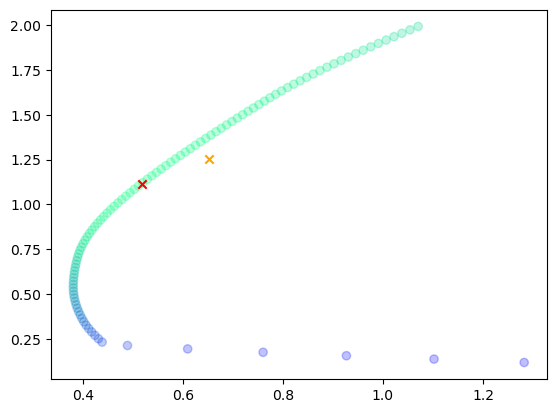

In [50]:
X,Y,Z,C=current_risk.efficient_frontier()

opt_res=current_risk.performance(current_optimal_weights),current_risk.variance(current_optimal_weights)
current_res=current_risk.performance(current_weights),current_risk.variance(current_weights)

plt.scatter(Z,Y,c=C,cmap="winter",alpha=0.25,marker='o')
plt.scatter(opt_res[1],opt_res[0],c='red',marker='x')
plt.scatter(current_res[1],current_res[0],c='orange',marker='x')

## Real Portfolio vs Optimal

In [52]:
current_holding_comparison=holding.copy()
current_holding_comparison=current_holding_comparison.loc[current_holding_comparison.index!="Total"]
current_holding_comparison=pd.concat([current_holding_comparison,optimal_ptf_current],axis=1)
current_holding_comparison['Spread']=current_holding_comparison['Weights']-current_holding_comparison['Optimal Weights']
current_holding_comparison['Weights']=current_holding_comparison['Weights'].round(7)
current_holding_comparison=current_holding_comparison.fillna(0)
current_holding_comparison

,Price in USDT,Weights,Optimal Weights,Spread
OMUSDT,1808.535706,0.435937,0.324157,0.111780
BTCUSDT,907.773701,0.218814,0.459405,-0.240591
JASMYUSDT,571.970640,0.137870,0.000000,0.000000
SOLUSDT,393.324540,0.094809,0.000000,0.000000
ETHUSDT,269.393214,0.064936,0.000000,0.000000
TRXUSDT,138.529835,0.033392,0.197177,-0.163785
BBUSDT,57.868502,0.013949,0.000000,0.000000
BNBUSDT,1.219922,0.000294,0.000000,0.000000
PEPEUSDT,0.000006,0.000000,0.019261,-0.019261


In [53]:
historical_comparison=holding.copy()
historical_comparison=historical_comparison.loc[historical_comparison.index!="Total"]
historical_comparison=pd.concat([historical_comparison,inventory],axis=1)
historical_comparison['Spread']=historical_comparison['Weights']-historical_comparison['Optimal Weights']
historical_comparison['Weights']=historical_comparison['Weights'].round(7)
historical_comparison=historical_comparison.fillna(0)
historical_comparison

,Price in USDT,Weights,Optimal Weights,Spread
OMUSDT,1808.535706,0.435937,0.361366,0.074571
BTCUSDT,907.773701,0.218814,0.300000,-0.081186
JASMYUSDT,571.970640,0.137870,0.023271,0.114599
SOLUSDT,393.324540,0.094809,0.000000,0.000000
ETHUSDT,269.393214,0.064936,0.000000,0.000000
TRXUSDT,138.529835,0.033392,0.072233,-0.038841
BBUSDT,57.868502,0.013949,0.000000,0.000000
BNBUSDT,1.219922,0.000294,0.024593,-0.024299
PEPEUSDT,0.000006,0.000000,0.092031,-0.092031
SUIUSDT,0.000000,0.000000,0.075958,0.000000


# Risk Reward Analysis

In [55]:
opt_ptf=(returns_to_use*opt_weights).sum(axis=1)
curr_opt_ptf=(ex_ante_perf*current_optimal_weights).sum(axis=1)
portfolio_perf=pd.DataFrame()
portfolio_perf['Portfolio']=(ex_ante_perf*current_weights).sum(axis=1)

In [56]:
portfolio_perf['Bitcoin']=returns['BTCUSDT']
portfolio_perf['Optimal']=opt_ptf
portfolio_perf['Current Optimal']=curr_opt_ptf

<Axes: >

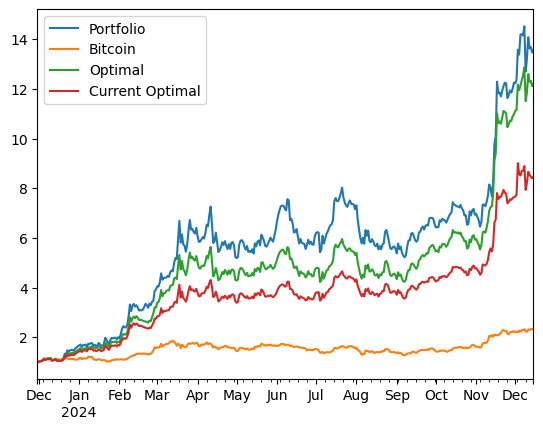

In [57]:
(1+portfolio_perf.loc[:]).cumprod().plot()

In [58]:
current_perf=portfolio_perf.copy()
current_perf=current_perf.loc[historical_ptf.index]
current_perf['Historical Portfolio']=historical_ptf['Historical Portfolio']

<Axes: >

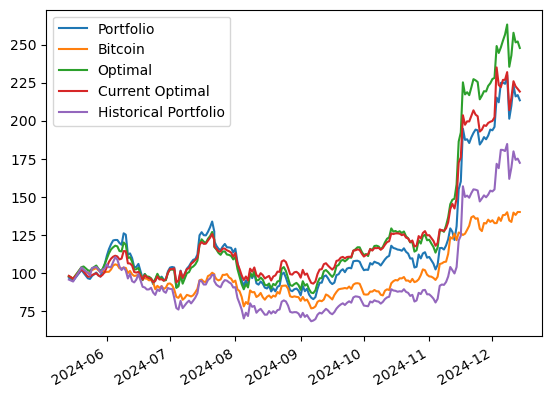

In [59]:
((1+current_perf).cumprod()*100).plot()

In [60]:
((1+current_perf).cumprod()*100).iloc[-10:]

,Portfolio,Bitcoin,Optimal,Current Optimal,Historical Portfolio
2024-12-05,224.799730,134.162033,248.082403,222.037073,180.882889
2024-12-06,225.025750,137.975577,252.556947,226.776777,180.754476
2024-12-07,224.209219,138.101611,256.619838,226.861779,180.041463
2024-12-08,230.074524,139.857753,263.145253,231.878212,184.701345
2024-12-09,201.275415,134.452552,235.401983,206.909635,161.779517
2024-12-10,209.784009,133.504547,242.874828,214.964869,169.133901
2024-12-11,223.118502,139.625877,257.726031,225.907078,179.858235
2024-12-12,215.952637,138.069846,251.417799,222.520171,174.270669
2024-12-13,216.813611,140.016510,252.001131,220.872699,175.078776
2024-12-14,213.381780,140.010643,247.745450,219.110242,172.317363


## Volatilities

In [62]:
vol=historical_risk.portfolio(opt_weights).std()*np.sqrt(252)
vol_ex_ante=historical_risk.variance(opt_weights)

vol,vol_ex_ante

(Portfolio    0.630916
 dtype: float64,
 0.6317172378393519)

In [63]:
vol=current_risk.portfolio(current_weights).std()*np.sqrt(252)
vol_ex_ante=current_risk.variance(current_weights)
vol,vol_ex_ante

(Portfolio    0.651989
 dtype: float64,
 0.6519892742788422)

In [64]:
portfolio_perf.iloc[1:].std()*np.sqrt(252)

Portfolio          0.719790
Bitcoin            0.433953
Optimal            0.631717
Current Optimal    0.563469
dtype: float64

In [65]:
current_risk.tracking_error(current_risk.returns['BTCUSDT'],current_perf['Historical Portfolio'])

0.46510522571341767

## Risk Contribution

In [67]:
perf_analysis=pd.concat([historical_risk.perf_contrib(opt_weights),historical_risk.var_contrib_pct(opt_weights)],axis=1)
perf_analysis

,Performance Contribution,Initial Weights,Last Weights,Variance Contribution in %,Idiosyncratic Risk in %,Correlation in %
BNBUSDT,0.040593,0.024593,0.003129,0.008969,0.000348,0.008621
BTCUSDT,0.407647,0.300000,0.033971,0.137535,0.042470,0.095065
JASMYUSDT,0.062597,0.023271,0.004122,0.017243,0.001719,0.015524
OMUSDT,18.401836,0.361366,0.900733,0.642785,0.535840,0.106945
PEPEUSDT,0.538960,0.092031,0.030291,0.096806,0.034088,0.062718
SUIUSDT,0.222140,0.075958,0.014310,0.051893,0.013301,0.038592
TRXUSDT,0.074866,0.072233,0.007062,0.022968,0.006245,0.016723
XLMUSDT,0.038979,0.027391,0.003186,0.011441,0.001121,0.010319
XRPUSDT,0.043419,0.023156,0.003196,0.010361,0.000589,0.009772


In [68]:
perf_analysis=pd.concat([current_risk.perf_contrib(current_optimal_weights),current_risk.var_contrib_pct(current_optimal_weights)],axis=1)
perf_analysis

,Performance Contribution,Initial Weights,Last Weights,Variance Contribution in %,Idiosyncratic Risk in %,Correlation in %
OMUSDT,0.817474,0.324157,0.517288,0.578948,0.449499,0.129449
BTCUSDT,0.237575,0.459405,0.315811,0.234406,0.132996,0.101410
TRXUSDT,0.143205,0.197177,0.154232,0.169202,0.112813,0.056389
PEPEUSDT,0.008702,0.019261,0.012670,0.017444,0.001673,0.015771


In [69]:
perf_analysis=pd.concat([current_risk.perf_contrib(current_weights),current_risk.var_contrib_pct(current_weights)],axis=1)
perf_analysis

,Performance Contribution,Initial Weights,Last Weights,Variance Contribution in %,Idiosyncratic Risk in %,Correlation in %
OMUSDT,1.120820,0.444444,0.664420,0.657065,0.532341,0.124724
BTCUSDT,0.114919,0.222222,0.143109,0.087699,0.019605,0.068094
JASMYUSDT,0.069997,0.141414,0.089739,0.142844,0.056180,0.086664
SOLUSDT,0.022754,0.090909,0.048247,0.062502,0.007993,0.054508
ETHUSDT,0.009829,0.060606,0.029898,0.027667,0.002567,0.025100
TRXUSDT,0.022008,0.030303,0.022205,0.011814,0.001679,0.010135
BBUSDT,-0.004492,0.010101,0.002381,0.010409,0.000395,0.010015


# Value At Risk

## Historical

### Optimal Weights

In [73]:
var,cvar=historical_risk.historical_var(opt_weights)
(var,cvar)

(-0.051097439406628406, -0.07408499514957143)

### Current Weights

In [75]:
var,cvar=current_risk.historical_var(current_weights)
(var,cvar)

(-0.04838242805754581, -0.07503686366378239)

In [76]:
historical_var=current_risk.returns*current_weights
historical_var['Portfolio']=historical_var.sum(axis=1)
historical_var=historical_var.sort_values(by='Portfolio')
centile=0.05
row=round(historical_var.shape[0]*centile)

In [77]:
var=historical_var.iloc[row]
var

OMUSDT      -0.017293
BTCUSDT     -0.011387
JASMYUSDT   -0.011485
SOLUSDT     -0.006930
ETHUSDT      0.000953
TRXUSDT     -0.001889
BBUSDT      -0.000126
BNBUSDT     -0.000000
PEPEUSDT    -0.000000
Portfolio   -0.048157
Name: 2024-11-25 00:00:00, dtype: float64

In [78]:
cvar=historical_var.iloc[:row+1].mean()
cvar

OMUSDT      -0.042078
BTCUSDT     -0.007667
JASMYUSDT   -0.012596
SOLUSDT     -0.006181
ETHUSDT     -0.002453
TRXUSDT     -0.000939
BBUSDT      -0.000884
BNBUSDT      0.000000
PEPEUSDT     0.000000
Portfolio   -0.072797
dtype: float64

## Parametric

### Optimal Weights

In [81]:
var,cvar=historical_risk.parametric_var(opt_weights)

(var,cvar)

(-0.06545603798326005, -0.08389654310234075)

### Current Weights

In [83]:
var,cvar=current_risk.parametric_var(current_weights)

(var,cvar)

(-0.06755654610255687, -0.08658881375294858)

## Multivariate

### Optimal Weights

In [86]:
perf=performance(historical_risk.multivariate_distribution(),opt_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()
(var,cvar)

(-0.05847787620562361, -0.07506916945864804)

### Current Weights

In [88]:
perf=performance(current_risk.multivariate_distribution(),current_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()
(var,cvar)

(-0.06268910637780775, -0.0788996562411414)

In [89]:
scenario_multivariate={}

for i in range(50):
    multivariate_distrib=pd.DataFrame(current_risk.multivariate_distribution(),columns=current_risk.returns.columns)
    multivariate_distrib=multivariate_distrib*current_weights
    multivariate_distrib=multivariate_distrib[multivariate_distrib.columns[current_weights>0]]

    multivariate_distrib['Portfolio']=multivariate_distrib.sum(axis=1)
    multivariate_var=multivariate_distrib.sort_values(by='Portfolio').iloc[int(multivariate_distrib.shape[0]*0.05)]['Portfolio']
    results=multivariate_distrib.sort_values(by='Portfolio').iloc[int(multivariate_distrib.shape[0]*0.05)]

    scenario_multivariate[i]=results.to_dict()

mean_scenario_multivariate=pd.DataFrame(scenario_multivariate).T.mean()
mean_scenario_multivariate

OMUSDT      -0.038482
BTCUSDT     -0.006624
JASMYUSDT   -0.009255
SOLUSDT     -0.004335
ETHUSDT     -0.001973
TRXUSDT     -0.001189
BBUSDT      -0.000828
Portfolio   -0.062686
dtype: float64

## Copulas

## Gaussian Copula

### Optimal Weights

In [93]:
cop=historical_risk.gaussian_copula()
perf=performance(cop,opt_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.057083469550108526, -0.07364693775077896)

### Current Weights

In [95]:
cop=current_risk.gaussian_copula()
perf=performance(cop,current_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.06233421768257186, -0.07941273274038274)

In [96]:
scenario_gaussian={}

for i in range(100):
    gaussian_copula_distrib=pd.DataFrame(current_risk.gaussian_copula(),columns=current_risk.returns.columns)

    gaussian_copula_distrib=gaussian_copula_distrib*current_weights
    gaussian_copula_distrib=gaussian_copula_distrib[gaussian_copula_distrib.columns[current_weights>0]]

    gaussian_copula_distrib['Portfolio']=gaussian_copula_distrib.sum(axis=1)
    gaussian_var=gaussian_copula_distrib.sort_values(by='Portfolio').iloc[int(gaussian_copula_distrib.shape[0]*0.05)]['Portfolio']
    results=gaussian_copula_distrib.sort_values(by='Portfolio').iloc[int(gaussian_copula_distrib.shape[0]*0.05)]
    
    scenario_gaussian[i]=results
    
mean_scenario_gaussian=pd.DataFrame(scenario_gaussian).T.mean()
mean_scenario_gaussian

OMUSDT      -0.042816
BTCUSDT     -0.004736
JASMYUSDT   -0.008142
SOLUSDT     -0.003965
ETHUSDT     -0.001658
TRXUSDT     -0.000599
BBUSDT      -0.000613
Portfolio   -0.062529
dtype: float64

## Student Copula

### Optimal Weights

In [99]:
t_copula=historical_risk.t_copula()
perf=performance(t_copula,opt_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.05606780013819832, -0.07306336349944176)

### Current Weights

In [101]:
t_copula=current_risk.t_copula()
perf=performance(t_copula,current_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.06372843004986775, -0.08154070522245005)

In [102]:
scenario_t_copula={}

for i in range(100):
    
    t_copula_distrib=pd.DataFrame(current_risk.t_copula(),columns=current_risk.returns.columns)
    t_copula_distrib=t_copula_distrib*current_weights
    t_copula_distrib=t_copula_distrib[t_copula_distrib.columns[current_weights>0]]
    t_copula_distrib['Portfolio']=t_copula_distrib.sum(axis=1)
    t_copula_var=t_copula_distrib.sort_values(by='Portfolio').iloc[int(t_copula_distrib.shape[0]*0.05)]['Portfolio']
    results=t_copula_distrib.sort_values(by='Portfolio').iloc[int(t_copula_distrib.shape[0]*0.05)]
    
    scenario_t_copula[i]=results
    
mean_scenario_gaussian=pd.DataFrame(scenario_t_copula).T.mean()
mean_scenario_gaussian

OMUSDT      -0.041732
BTCUSDT     -0.005443
JASMYUSDT   -0.008945
SOLUSDT     -0.004162
ETHUSDT     -0.001871
TRXUSDT     -0.000759
BBUSDT      -0.000810
Portfolio   -0.063723
dtype: float64

## Gumbel Copula

### Optimal Weights

In [105]:
gumbel_copula=historical_risk.gumbel_copula()
perf=performance(gumbel_copula,opt_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.10664780839554883, -0.1505433758331018)

### Current Weights

In [107]:
gumbel_copula=current_risk.gumbel_copula(theta=2)
perf=performance(gumbel_copula,current_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.1137298047000527, -0.1576509368438829)

In [108]:
scenario_gumbel_copula={}

for i in range(100):
    
    gumbel_copula_distrib=pd.DataFrame(current_risk.gumbel_copula(),columns=current_risk.returns.columns)
    gumbel_copula_distrib=gumbel_copula_distrib*current_weights
    gumbel_copula_distrib=gumbel_copula_distrib[gumbel_copula_distrib.columns[current_weights>0]]
    gumbel_copula_distrib['Portfolio']=gumbel_copula_distrib.sum(axis=1)
    gumbel_copula_var=gumbel_copula_distrib.sort_values(by='Portfolio').iloc[int(gumbel_copula_distrib.shape[0]*0.05)]['Portfolio']
    results=gumbel_copula_distrib.sort_values(by='Portfolio').iloc[int(gumbel_copula_distrib.shape[0]*0.05)]
    
    scenario_gumbel_copula[i]=results
    
mean_scenario_gaussian=pd.DataFrame(scenario_gumbel_copula).T.mean()
mean_scenario_gaussian

OMUSDT      -0.097287
BTCUSDT     -0.003831
JASMYUSDT   -0.009565
SOLUSDT      0.000071
ETHUSDT      0.000131
TRXUSDT     -0.000470
BBUSDT       0.000091
Portfolio   -0.110860
dtype: float64

## Monte Carlo

### Optimal

In [111]:
spot=data[with_no_na].iloc[-1]
monte_carlo=historical_risk.monte_carlo(spot,horizon=1/250,stress_factor=1.0)
perf=performance(monte_carlo[1].fillna(0),opt_weights)

In [112]:
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.06707685467146114, -0.08473634293289786)

### Current Weights

In [114]:
spot=data[ex_ante_perf.columns].iloc[-1]
monte_carlo=current_risk.monte_carlo(spot,horizon=1/250,stress_factor=1.0)
perf=performance(monte_carlo[1].fillna(0),current_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.06874677099499761, -0.08654748826270532)

In [115]:
spot=data[ex_ante_perf.columns].iloc[-1]

scenario_monte_carlo={}

for i in range(100):
    
    monte_carlo=current_risk.monte_carlo(spot,horizon=1/250,stress_factor=1.0)
    monte_carlo_distrib=monte_carlo[1].fillna(0)*current_weights
    monte_carlo_distrib=monte_carlo_distrib[monte_carlo_distrib.columns[current_weights>0]]
    monte_carlo_distrib['Portfolio']=monte_carlo_distrib.sum(axis=1)
    monte_carlo_var=monte_carlo_distrib.sort_values(by='Portfolio').iloc[int(monte_carlo_distrib.shape[0]*0.05)]['Portfolio']
    results=monte_carlo_distrib.sort_values(by='Portfolio').iloc[int(monte_carlo_distrib.shape[0]*0.05)]
    
    scenario_monte_carlo[i]=results
    
mean_scenario_monte_carlo=pd.DataFrame(scenario_monte_carlo).T.mean()
mean_scenario_monte_carlo

OMUSDT      -0.046536
BTCUSDT     -0.005743
JASMYUSDT   -0.009345
SOLUSDT     -0.003960
ETHUSDT     -0.001944
TRXUSDT     -0.000778
BBUSDT      -0.000664
Portfolio   -0.068971
dtype: float64

## VaR Violation

In [117]:
var_data=rolling_var(returns_to_use,opt_weights,window=30,Q=1)
var_data

,Historical,Parametric,Multivariate,Portfolio
2024-01-14,-0.054322,-0.091163,-0.077190,-0.025682
2024-01-15,-0.054322,-0.091181,-0.075711,0.018274
2024-01-16,-0.054322,-0.090776,-0.074694,0.040529
2024-01-17,-0.054322,-0.092452,-0.079587,-0.026765
2024-01-18,-0.054322,-0.095254,-0.081337,-0.039414
...,...,...,...,...
2024-12-11,-0.089479,-0.126377,-0.104433,0.061148
2024-12-12,-0.089479,-0.127825,-0.109932,-0.024477
2024-12-13,-0.089479,-0.127878,-0.107578,0.002320
2024-12-14,-0.089479,-0.127227,-0.110419,-0.016888


In [118]:
current_var_data=rolling_var(ex_ante_perf_to_use,current_weights,window=15,Q=1)
current_var_data

,Historical,Parametric,Multivariate,Portfolio
2024-05-28,-0.035107,-0.084855,-0.078747,-0.017735
2024-05-29,-0.035107,-0.082202,-0.077009,-0.008846
2024-05-30,-0.035107,-0.072463,-0.065928,0.040402
2024-05-31,-0.035107,-0.073546,-0.062579,0.039741
2024-06-01,-0.035107,-0.077180,-0.068932,0.053545
...,...,...,...,...
2024-12-11,-0.109672,-0.114749,-0.100292,0.063563
2024-12-12,-0.112145,-0.117912,-0.108038,-0.032117
2024-12-13,-0.112145,-0.117445,-0.105547,0.003987
2024-12-14,-0.112145,-0.118513,-0.106686,-0.015828


<Axes: >

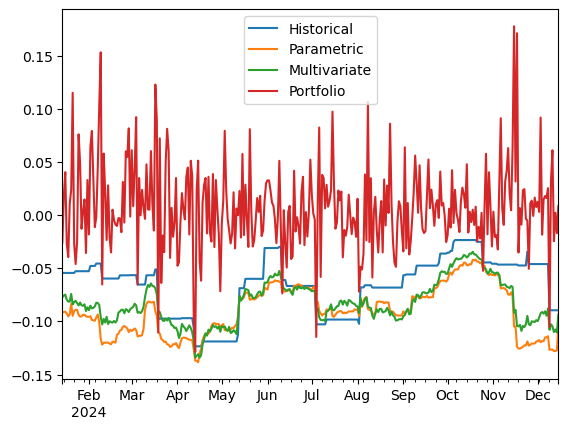

In [119]:
var_data.plot()

<Axes: >

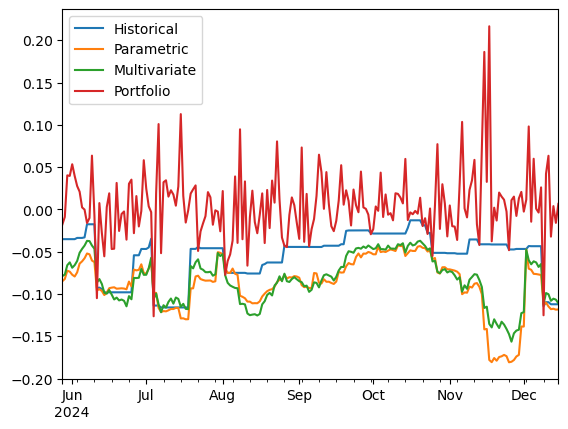

In [120]:
current_var_data.plot()

In [121]:
kupiec_test(var_data)

,Historical,Parametric,Multivariate
Proportion of failure,0.026706,0.011869,0.011869
Kupiec Stat,4.602656,14.70455,14.70455
P-value,0.031922,0.000126,0.000126


In [122]:
kupiec_test(current_var_data)

,Historical,Parametric,Multivariate
Proportion of failure,0.064356,0.019802,0.014851
Kupiec Stat,0.80681,4.981952,7.175969
P-value,0.369065,0.025613,0.007389


# Principal Component Analysis

## Historical PCA

In [125]:
eigval,eigvec,portfolio_components=historical_risk.pca(num_components=5)
variance_explained=eigval/eigval.sum()
variance_explained

array([0.76863682, 0.07391264, 0.0588491 , 0.05272433, 0.0458771 ])

In [126]:
pca_weight=dict((portfolio_components['PC1']/portfolio_components['PC1'].sum()))
portfolio_components['PC1']

AAVEUSDT    0.014894
ADAUSDT     0.015236
ALGOUSDT    0.017086
APTUSDT     0.016127
ARBUSDT     0.016919
              ...   
WBTCUSDT    0.009268
WLDUSDT     0.021937
XLMUSDT     0.012077
XRPUSDT     0.010580
XTZUSDT     0.016057
Name: PC1, Length: 63, dtype: float64

<Axes: >

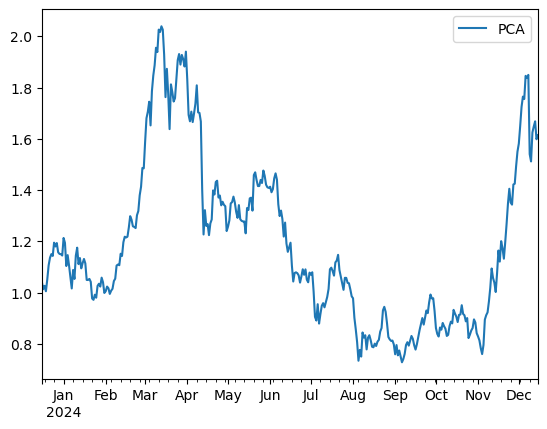

In [127]:
historical_PCA=pd.DataFrame(np.array(list(pca_weight.values())).dot(np.transpose(historical_risk.returns)),
                 index=historical_risk.returns.index,
                 columns=['PCA'])
historical_PCA=historical_PCA.dropna()
(1+historical_PCA).cumprod().plot()

<Axes: >

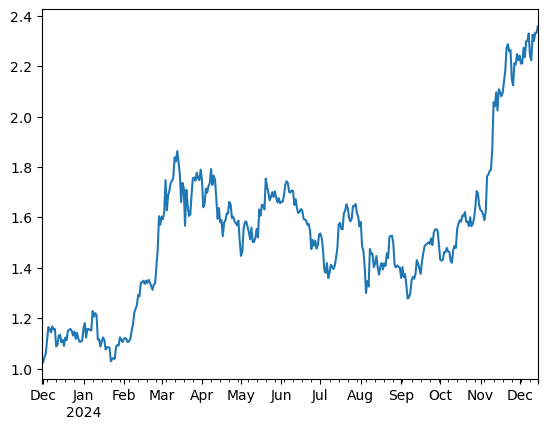

In [128]:
(1+historical_risk.returns['BTCUSDT']).cumprod().plot()

In [129]:
comparison=historical_risk.returns.copy()
comparison['PCA']=historical_PCA
distances=np.sqrt(np.sum(comparison.apply(lambda y:(y-historical_PCA['PCA'])**2))).sort_values()
distances

C:\Users\Admin\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


PCA          0.000000
FLOWUSDT     0.418656
WBETHUSDT    0.420784
ETHUSDT      0.420854
ATOMUSDT     0.447110
               ...   
FLOKIUSDT    1.128846
BONKUSDT     1.130796
WLDUSDT      1.134130
PEPEUSDT     1.182893
OMUSDT       1.533059
Length: 64, dtype: float64

<Axes: >

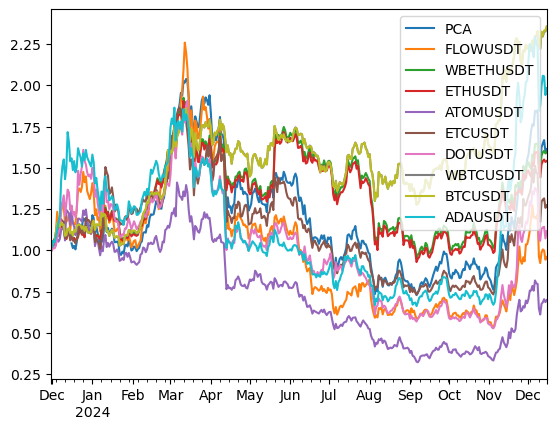

In [130]:
(1+comparison[distances.index[:10]]).cumprod().plot()

<Axes: >

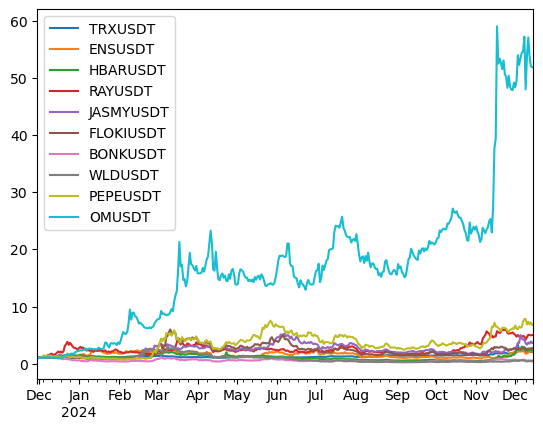

In [131]:
(1+comparison[distances.index[-10:]]).cumprod().plot()

## Current PCA

In [133]:
eigval,eigvec,portfolio_components_current=current_risk.pca(num_components=5)
variance_explained=eigval/eigval.sum()
variance_explained

array([0.53194516, 0.15400049, 0.1348285 , 0.10263978, 0.07658607])

In [134]:
pca_weight=dict((portfolio_components_current['PC1']/portfolio_components_current['PC1'].sum()))
portfolio_components_current['PC1']

OMUSDT       0.102079
BTCUSDT      0.061488
JASMYUSDT    0.167582
SOLUSDT      0.101167
ETHUSDT      0.082479
TRXUSDT      0.049192
BBUSDT       0.213555
BNBUSDT      0.067721
PEPEUSDT     0.154737
Name: PC1, dtype: float64

<Axes: >

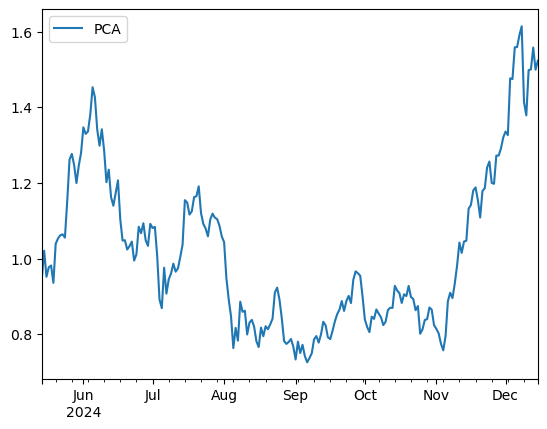

In [135]:
PCA=pd.DataFrame(np.array(list(pca_weight.values())).dot(np.transpose(current_risk.returns)),
                 index=current_risk.returns.index,
                 columns=['PCA'])
PCA=PCA.dropna()
(1+PCA).cumprod().plot()

<Axes: >

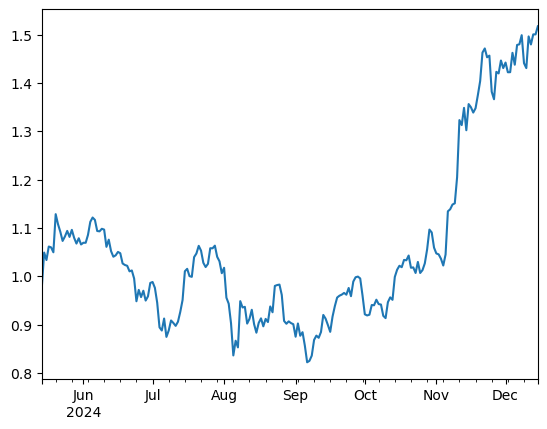

In [136]:
(1+current_risk.returns['BTCUSDT']).cumprod().plot()

In [137]:
comparison=current_risk.returns.copy()
comparison['PCA']=PCA
distances=np.sqrt(np.sum(comparison.apply(lambda y:(y-PCA['PCA'])**2))).sort_values()
distances.iloc[:10]

C:\Users\Admin\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


PCA          0.000000
SOLUSDT      0.388230
ETHUSDT      0.407893
BNBUSDT      0.411836
BTCUSDT      0.427727
JASMYUSDT    0.646957
PEPEUSDT     0.712516
BBUSDT       0.725478
TRXUSDT      0.881001
OMUSDT       0.881503
dtype: float64

<Axes: >

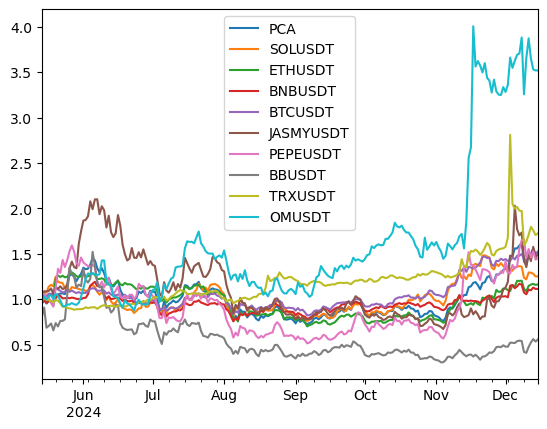

In [138]:
(1+comparison[distances.index[:10]]).cumprod().plot()

## Sensitivity Analysis

In [140]:
beta=(ex_ante_perf.cov()/ex_ante_perf.var())['BTCUSDT'].sort_values(ascending=False)
beta

PEPEUSDT     1.899480
BBUSDT       1.570671
JASMYUSDT    1.246837
SOLUSDT      1.145512
BTCUSDT      1.000000
ETHUSDT      0.956063
OMUSDT       0.890651
BNBUSDT      0.663835
TRXUSDT      0.264712
Name: BTCUSDT, dtype: float64

In [141]:
days=15
beta=(ex_ante_perf.iloc[-days:].cov()/ex_ante_perf.iloc[-days:].var())['BTCUSDT'].sort_values(ascending=False)
beta

BBUSDT       2.651152
PEPEUSDT     1.715868
ETHUSDT      1.487914
OMUSDT       1.204103
BNBUSDT      1.089925
SOLUSDT      1.019671
BTCUSDT      1.000000
JASMYUSDT    0.336647
TRXUSDT     -0.075922
Name: BTCUSDT, dtype: float64

### Multilinear Regression

In [143]:
reg=ex_ante_perf.copy().dropna()
reg=reg.iloc[-30:]
reg['PCA']=historical_PCA
X=reg.iloc[:,reg.columns!='PCA'].to_numpy()
Y=reg['PCA'].to_numpy()
columns=list(reg.columns[reg.columns!='PCA'])

beta=np.dot(np.linalg.inv(np.dot(X.T,X)),np.dot(X.T,Y))

In [144]:
table=pd.DataFrame(dict(zip(columns,beta)).values(),index=dict(zip(columns,beta)).keys(),columns=['Beta'])
table.sort_values(by='Beta',ascending=False)

,Beta
BTCUSDT,0.656002
ETHUSDT,0.400735
BBUSDT,0.291334
BNBUSDT,0.256360
JASMYUSDT,0.119098
OMUSDT,0.066701
TRXUSDT,-0.017762
PEPEUSDT,-0.160536
SOLUSDT,-0.296427


### Regression to PCA

In [146]:
reg=ex_ante_perf.copy().dropna()
reg=reg.loc[historical_ptf['Historical Portfolio'].index]

reg['PCA']=historical_PCA
reg['Portfolio']=historical_ptf['Historical Portfolio']
reg=reg.iloc[-15:]
X=reg['PCA'].to_numpy()
Y=reg['Portfolio'].to_numpy()
columns=list(reg.columns[reg.columns!='Porfolio'])

beta=reg.cov()['Portfolio']['PCA']/reg.var()['Portfolio']
beta

0.739898288099771

In [147]:
reg=ex_ante_perf.copy().dropna()
reg['PCA']=historical_PCA

(reg.cov()['PCA']/reg.var()).sort_values(ascending=False)

BTCUSDT      1.255074
BNBUSDT      1.110947
PCA          1.000000
ETHUSDT      0.975921
SOLUSDT      0.799725
JASMYUSDT    0.404692
PEPEUSDT     0.367921
BBUSDT       0.349696
OMUSDT       0.232680
TRXUSDT      0.181461
dtype: float64

In [148]:
reg=ex_ante_perf.copy().dropna().iloc[-15:]
reg['PCA']=historical_PCA

(reg.cov()['PCA']/reg.var()).sort_values(ascending=False)

BTCUSDT      1.908482
ETHUSDT      1.260131
SOLUSDT      1.165265
PCA          1.000000
BNBUSDT      0.862504
BBUSDT       0.563199
OMUSDT       0.535344
JASMYUSDT    0.163619
PEPEUSDT     0.118988
TRXUSDT      0.111277
dtype: float64

### Correlation Matrix

<Axes: >

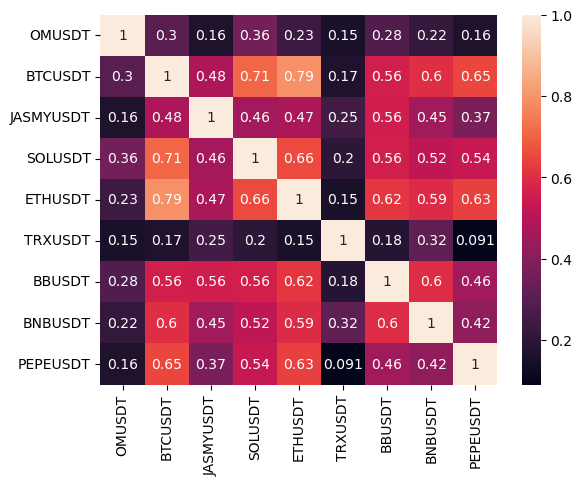

In [150]:
sns.heatmap(ex_ante_perf.corr(),annot=True)

<Axes: >

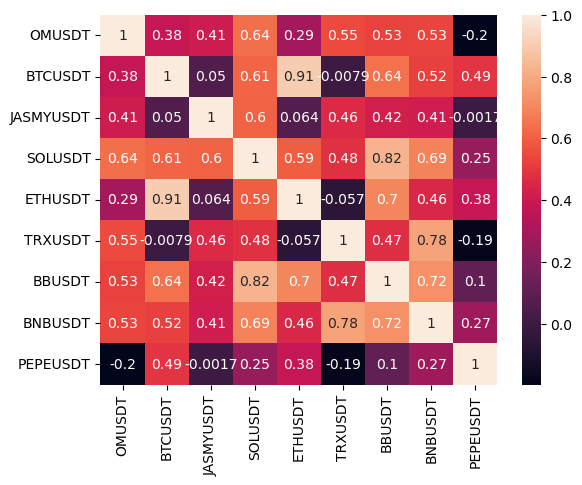

In [151]:
sns.heatmap(ex_ante_perf.iloc[-15:].corr(),annot=True)

## Sliding window optimization

In [153]:
results={}
window=14

for i in range(0,ex_ante_perf_to_use.shape[0]-window+1,window):
    
    try:
        dataset=ex_ante_perf_to_use.iloc[i:i+window]
        risk=RiskAnalysis(dataset)
        date=dataset.index[-1]
        optimal=risk.optimize(objective='sharpe_ratio')     
        results[date]=np.round(optimal,6)
        
    except Exception as e:
        
            pass

rolling_optimization=pd.DataFrame(results,index=ex_ante_perf_to_use.columns).T
rolling_optimization

,OMUSDT,BTCUSDT,JASMYUSDT,SOLUSDT,ETHUSDT,TRXUSDT,BBUSDT,BNBUSDT,PEPEUSDT
2024-05-27,0.000000,0.000000,0.621968,0.000000,0.000000,0.000000,0.00000,0.000000,0.378032
2024-06-10,0.625939,0.000000,0.150852,0.000000,0.000000,0.223209,0.00000,0.000000,0.000000
2024-06-24,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.00000,0.000000,0.000000
2024-07-08,0.182528,0.000000,0.000000,0.000000,0.000000,0.817472,0.00000,0.000000,0.000000
2024-07-22,0.133242,0.414562,0.000000,0.112009,0.000000,0.340186,0.00000,0.000000,0.000000
2024-08-05,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
2024-08-19,0.000000,0.000000,0.000000,0.000000,0.000000,0.926694,0.00000,0.073306,0.000000
2024-09-02,0.435138,0.000000,0.000000,0.000000,0.000000,0.564862,0.00000,0.000000,0.000000
2024-09-16,0.287440,0.000000,0.000000,0.000000,0.000000,0.000000,0.71256,0.000000,0.000000
2024-09-30,0.176666,0.000000,0.000000,0.000000,0.165949,0.527049,0.00000,0.000000,0.130336


In [154]:
results={}
window=30
days=250
limit=np.where(returns_to_use.columns=='USDCUSDT')[0][0]

for i in range(0,returns_to_use.shape[0]-window+1,window):
    
    try:
        dataset=returns_to_use.iloc[-days:].iloc[i:i+window]
        risk=RiskAnalysis(dataset)
        date=dataset.index[-1]
        optimal=risk.optimize(objective='sharpe_ratio',constraints=[{'type': 'eq', 'fun': lambda weights: weights[limit]-0.0}])
        results[date]=np.round(optimal,6)
        
    except Exception as e:
        
            pass

rolling_optimization=pd.DataFrame(results,index=returns_to_use.columns).T
rolling_optimization

,AAVEUSDT,ADAUSDT,ALGOUSDT,APTUSDT,ARBUSDT,ARUSDT,ATOMUSDT,AVAXUSDT,BCHUSDT,BNBUSDT,...,TRXUSDT,UNIUSDT,USDCUSDT,VETUSDT,WBETHUSDT,WBTCUSDT,WLDUSDT,XLMUSDT,XRPUSDT,XTZUSDT
2024-05-09,0.000000,0.000003,0.0,0.000000,0.0,0.013059,0.0,0.0,0.0,0.0,...,0.037621,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000,0.0
2024-06-08,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000,0.0
2024-07-08,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.968182,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000,0.0
2024-08-07,0.443127,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.518687,0.0
2024-09-06,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.550875,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000,0.0
2024-10-06,0.012169,0.000000,0.0,0.098757,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.311741,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000,0.0
2024-11-05,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.472310,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000,0.0
2024-12-05,0.000000,0.077375,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.01436,0.171202,0.0
2024-12-15,0.537327,0.045846,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000,0.0


In [155]:
rolling_optimization.iloc[-1].sort_values(ascending=False)

AAVEUSDT     0.537327
PEPEUSDT     0.302413
FDUSDUSDT    0.114414
ADAUSDT      0.045846
WLDUSDT      0.000000
               ...   
GALAUSDT     0.000000
GRTUSDT      0.000000
HBARUSDT     0.000000
ICPUSDT      0.000000
XTZUSDT      0.000000
Name: 2024-12-15 00:00:00, Length: 63, dtype: float64